# Erlotinib PK Analysis

Run population anaysis of erlotinib PK data. First we reproduce the steps performed in the publication by Eigenmann et. al.. The next step is to challenge the modelling assumptions.

## 1. Reproduce PK Analysis

### 1.1 Import data

In [9]:
import os
import pandas as pd

# Import data
path = os.getcwd()
data_raw = pd.read_csv(path + '/data/PK_LXF_erlo.csv', sep=';')

# Filter relevant information
data = data_raw[['#ID', 'TIME', 'Y', 'DOSE GROUP', 'DOSE', 'BW']]

# Convert TIME and Y to numeric values (currently strings)
data['TIME'] = pd.to_numeric(data['TIME'], errors='coerce')
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

# Sort TIME values (for plotting convenience)
data.sort_values(by='TIME', inplace=True)

# Filter NaNs
data = data[data['Y'].notnull()]

# Show data
data

,#ID,TIME,Y,DOSE GROUP,DOSE,BW
412,139,9.992361,0.952,6.25,.,22.8
141,52,9.995833,8.060,25.00,.,25.9
435,161,10.010417,551.000,6.25,.,23.9
187,108,10.010417,2380.000,25.00,.,25.1
118,34,10.018750,3500.000,25.00,.,27.9
391,131,10.019444,1290.000,6.25,.,23.3
368,119,10.043056,1050.000,6.25,.,21.1
164,91,10.043750,4340.000,25.00,.,26.5
233,129,10.103472,2270.000,25.00,.,27.5
302,31,10.103472,848.000,6.25,.,25.3


### 1.2 Sort data into dosing groups

Each dose group has been dosed daily from day 2 to 16. PK samples have been taken on day 10 and 16.

In [16]:
# Get group identifiers
groups = data['DOSE GROUP'].unique()

# Sort into groups
data_one = data[data['DOSE GROUP'] == groups[0]]
data_two = data[data['DOSE GROUP'] == groups[1]]
data_three = data[data['DOSE GROUP'] == groups[2]]

# Show different dose groups
groups

array([  6.25,  25.  , 100.  ])

### 1.3 Visualise dose group one

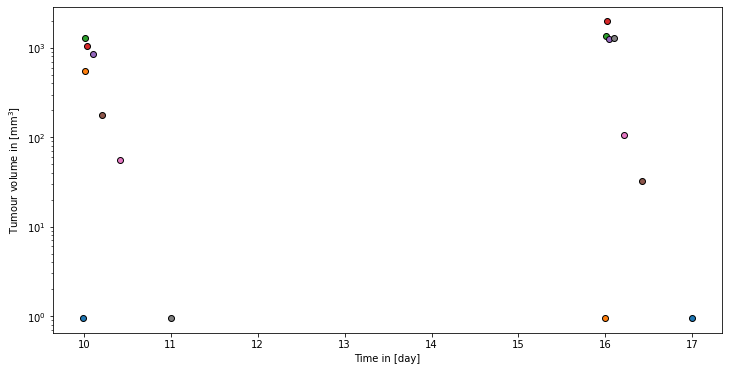

In [15]:
import matplotlib.pyplot as plt

# Get unique animal IDs
ids = data_one['#ID'].unique()

# Plot measurements
fig = plt.figure(figsize=(12, 6))

for i in ids:
    # Mask for individual
    mask = data_one['#ID'] == i
    time = data_one[mask]['TIME']
    volume = data_one[mask]['Y']

    # Filter out Nan values
    mask = volume.notnull()
    time = time[mask]
    volume = volume[mask]

    # Create semi log plot
    plt.scatter(time, volume, edgecolor='black')

    
# Set y axis to logscale
plt.yscale('log')

# Label axes
plt.xlabel('Time in [day]')
plt.ylabel(r'Tumour volume in [mm$^3$]')

plt.show()

### 1.2 Build Structural Model (pints.ForwardModel)

#### 1.2.1 Build Myokit Model

In [3]:
import myokit

from pkpd import model as m

# Build 1 compartmental PK model with default parameters
model = m.create_one_comp_pk_model()

# Validate model
model.validate()

# Check units
model.check_units(mode=myokit.UNIT_TOLERANT)

# Print model
print(model.code())

[[model]]
# Initial values
central.amount = 0

[central]
dot(amount) = -k_e * amount
    in [mg]
conc = amount / volume
    in [mg/L]
k_e = 0
    in [1/day]
time = 0 bind time
    in [day]
volume = 1
    in [L]




#### 1.2.2 Set oral administration 

In [ ]:
import myokit

class DosingRegimen(object):
    def __init__(self):
        self._amount = None
        self._duration = None
        self._periodicity = 0
        self._multiplier = 0
        self._dosing_regimen = None
        self._indirect_admin = False
        self._dosing_compartment = 'central'

    def __call__(self, model, amount, duration=None, periodicity=0, multiplier=0):
        """
        Returns the myokit.Model with appropriate structural adjustments for dosing,
        and a myokit.Protocol with the specified schedule.
        """
        if 

    
    def set_amdin(indirect=False):
        self.indirect_admin = indirect


def create_dosing_regimen(model, compartment, administration, amount, duration=None, periodicity=0, multiplier=0):
    """
    Returns a myokit.Protocol object with the specified dosing regimen, and alters the structural model, 
    by addition of bolus injection or dosing compartment.

    model -- myokit.Model
    compartment -- compartment with bolus injection or connection to dosing compartment
    administration -- type of administration: Injection into compartment or dosing compartment
    amount -- Applied dose
    duration -- How long did it take to apply the dose, if None duration is set to the smallest numerically stable duration,
                i.e. such that duration > 1e-6 and amount / duration < some upper value.
    periodicity -- In which intervals is dose applied. If 0 dose is applied once.
    multplier -- How often is dose applied? If 0, it's applied once for non-period and indefinitely for periodic schedules.
    """
    if not isinstance(model, myokit.Model):
        raise ValueError
    if not model.has_component(compartment):
        raise ValueError
    if administration != 'dosing compartment':
        raise NotImplementedError

    # Set dosing compartment
    dose_comp = model.get(compartment)
    if administration == 'dosing compartment':
        dose_comp = model.add_component('dose')
    
    # Add dose rate and regimen to dose compartment
    dose_rate = dose_comp.add_variable('dose_rate')
    regimen = dose_comp.add_variable('regimen')

    
    # define dosing regimen
    duration = 0.001  # [1 / d] how long does it take for dose to be in dosing compartment?
    dose_rate.set_rhs(25 * 0.2 / duration)  # 100 mg / kg / d let's estimate weight of mouse 0.2 kg
    dosing_regimen = myokit.Protocol()
    dosing_regimen.schedule(level=1, start=0, duration=duration)

#### 1.2.3 Build pints model

In [5]:
# Build pints model
pass

### 1.3 Build population model

This is the Hierarchical Log Prior of the model 

\begin{align}
\text{p}(\psi | \theta )\text{p}(\theta )
\end{align}

Should take a number of means and variances to construct $\text{p}(\theta )$ (Gaussian for means of $\text{p}(\psi | \theta )$ and half cauchy for variances of $\text{p}(\psi | \theta )$.

Think about whether this can be generalised for any structure.

Potentially best way: build a Hierarchical Log Posterior by combining a Likelihood and prior similar to PosteriorLogLikelihood, but appending the input params of the prior instead to the model params (this is the p(y|psi)p(psi|theta) bit). You have to provide posteriors for the population level paramers.

In that way a posterior can be constructed by passing any problem, any population distribution and any priors of the population distirbution parameters!

In [6]:
# Build hierarchical model 
pass

### 1.4 Build error model

This can be done by just using Loglikelihood from pints

In [7]:
pass

### Run inference

In [8]:
pass

### Visualise prediction